# Predicting Heart Disease

The aim of this project is to build, fit and compare a number of different binary classification models to try and predict whether a patient has heart disease using the 'Heart Disease Data Set' source from the UCI repository <cite data-cite = "heart-disease">(Created by Robert Detrano, Donated by David W Aha, 1989)</cite>. The specific dataset used for this project is known as the cleveland dataset, as it was taken from the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. The features include 5 numerical features and 8 nominal categorical features. The target feature is a binary feature, with 0 refering to a patient without heart disease and 1 refering to a patient with heart disease.

The report for this project is organised as follows:

* <a href='Over'>Section 2: (Overview)</a> outlines the method
* <a href='DataPrep'>Section 3: (Data Preparation)</a> outlines and summarises data preparation process and model evaluation strategy
* <a href='Hyper'>Section 4: (Hyperparameter Tuning)</a> describes the hyperparameter tuning process for each classification algorithm.
* <a href='Per'>Section 5: (Performance Comparison)</a> describes the performance comparison for each classification algorithm
* <a href='Limit'>Section 6: (Critiques and Limitations)</a> outlines the limitations of the approaches used in this report
* <a href='Summary'>Section 7: (Summary)</a> concise summary of the report

This project was compiled using Jupyter Lab, it includes both the python code and explanations throughout the project.


<a id='Over'></a>

# Overview

## Method

I have built the following classifiers to try and predict heart disease:

* KNN
* Gaussian Naive Bayes
* Bernoulli Naive Bayes
* Decision Tree
* Logistic Regression (both simplified and non-simplified)

Using the cleaned data from phase 1, the process of transforming the data begins by encoding the categorical descriptive features by one-hot-encoding and then scaling the numerical features. The transformed data set was then split into a train and test set with a 70:30 ratio. From this split, the training set consisted of 212 rows, and the test set contained 91 rows.

Before fitting one of the models mentioned above, the best features were selected using their respective F-scores inside a pipeline. In the pipeline, we consider 5, 10, 15, 20 and all the full set of 26 features (after encoding).

Using the feature selection inside a hyperparameter search within a single pipeline, a 5 fold stratified cross validation took place to fine tune the hyperparameters. The AUC (Area Under Curve) was used as a the performance metric for each classifier. The stratified cross validation was used as it will help in making sure each fold is a representative of the whole, by using the same proportions of class structures <cite data-cite = 'CrossVal'></cite>, enabling less biased results. This cross validation strategy is essential as the target variable in this data set is unbalanced. Feature sensitivity was also examined as a result of the hyperparameter search.

For Bernoulli Naive Bayes and the simplified Logistic Regression Models, new versions of the dataset were formed. With the Bernoulli Naive Bayes dataset looking at both a fully fitted binary model, whereby all the continuous features were binned and encoded, and a model that consists of just the binary variables. This was done to deal with the mixed dataset we have for this project. Like the Bernoulli Naive Bayes, the Logistic Regression model underwent two fits, one being a fully fitted model, and the other looking at a simplified model. To make a simplified model, the functions from the statsmodels.api, which contains the equivalent of the 'glm' function in R, were used in order to look into the p-value of each variable. From the p-value, predictors were cut until a satisfactory model was obtained. The simplified model was then tested against the other models.


Once the best model was identified for each classification model, a number of pairwise t-tests were performed, with a 10 fold cross validation performed against the test data. The performance metric was again the AUC score. Since there are a number of classifiers, the two Naive Bayes models and the two logistic regression models were tested first. The best models from each were then tested against the rest of the models, until the significantly best model was obtained. In addition to the pairwise t-tests, the confusion matrices and classification reports were printed for each model, allowing us to compare the recall score for each classifier.

<a id = '#DataPrep'></a>

# Data Preparation


## Loading Dataset

In [1]:
# imports and loading the dataset
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn import feature_selection as fs

In [2]:
heart_filename = 'heart.csv'
heart_df = pd.read_csv(heart_filename, sep=',', decimal = '.', header = None, 
                    names=['age','sex','cp', 
                           'trestbps', 'chol', 'fbs', 
                           'restecg', 'thalach', 'exang', 
                           'oldpeak', 'slope', 'ca', 'thal', 'target'])
#first row loads in as column names so remove the first row of values
heart_df = heart_df.ix[1:]
print(heart_df.head())
# we are now using The data from the UCI repository known as preprocessed.cleveland.data

    age sex cp trestbps   chol fbs restecg thalach exang oldpeak slope ca  \
1.0  63   1  3    145.0  233.0   1       0   150.0     0     2.3     0  0   
2.0  37   1  2    130.0  250.0   0       1   187.0     0     3.5     0  0   
3.0  41   0  1    130.0  204.0   0       0   172.0     0     1.4     2  0   
4.0  56   1  1    120.0  236.0   0       1   178.0     0     0.8     2  0   
5.0  57   0  0    120.0  354.0   0       1   163.0     1     0.6     2  0   

    thal target  
1.0    1      1  
2.0    2      1  
3.0    2      1  
4.0    2      1  
5.0    2      1  


### Checking For Missing Values

I will check for missing values just in case

In [3]:
heart_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

<a id ='Encode'></a>

## Encoding The Categorical Features

### Encoding The Target Feature


In [4]:
heart = heart_df.drop(['target'], axis=1)
target = heart_df['target']
target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [5]:
# one hot encoding
heart.dtypes

age         object
sex         object
cp          object
trestbps    object
chol        object
fbs         object
restecg     object
thalach     object
exang       object
oldpeak     object
slope       object
ca          object
thal        object
dtype: object

### Changing Data Types for Numerical Features


In [6]:
col_list = ['trestbps', 'chol', 'thalach', 'oldpeak']
for item in col_list:
    heart[item] = heart[item].astype(str).astype(float)
    
col_list2 = ['age']
for item2 in col_list2:
    heart[item2] = heart[item2].astype(str).astype(np.int64)
    
col_list3 = ['sex','cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for item3 in col_list3:
    heart[item3] = heart[item3].astype(str).astype('object')
    
heart.dtypes

age           int64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
dtype: object

### Encoding Categorical Descriptive Features


In [7]:
categorical_cols = heart.columns[heart.dtypes==object].tolist()
categorical_cols

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [8]:
for col in categorical_cols:
    n = len(heart[col].unique())
    if (n == 2):
        heart[col] = pd.get_dummies(heart[col], drop_first=True)
   
# use one-hot-encoding for categorical features with >2 levels
heart = pd.get_dummies(heart)

The new data frame above shows any categorical feature with over 2 values being parsed into a new binary column. The number of columns has increased to 26.

In [9]:
heart.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2',
       'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3',
       'thal_0', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')

Here we see all the new columns that have been one-hot-encoded

In [10]:
heart.sample(5, random_state=999)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_0,cp_1,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
257.0,58,1,128.0,259.0,0,130.0,1,3.0,1,0,...,1,0,0,0,1,0,0,0,0,1
279.0,58,0,136.0,319.0,1,152.0,0,0.0,0,1,...,0,1,0,0,1,0,0,0,1,0
124.0,54,0,108.0,267.0,0,167.0,0,0.0,0,0,...,0,1,1,0,0,0,0,0,1,0
129.0,52,0,136.0,196.0,0,169.0,0,0.1,0,0,...,1,0,1,0,0,0,0,0,1,0
157.0,47,1,130.0,253.0,0,179.0,0,0.0,0,0,...,0,1,1,0,0,0,0,0,1,0


### Data Scaling

I will now apply min-max scaling to these features

In [11]:
from sklearn import preprocessing

heart_copy = heart.copy()
df = heart.copy()
Data_scaler = preprocessing.MinMaxScaler()
Data_scaler.fit(heart)
heart = Data_scaler.fit_transform(heart)

In [12]:
pd.DataFrame(heart, columns=heart_copy.columns).sample(5, random_state=999)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_0,cp_1,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
256,0.604167,1.0,0.320755,0.303653,0.0,0.450382,1.0,0.483871,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
278,0.604167,0.0,0.396226,0.440639,1.0,0.618321,0.0,0.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
123,0.520833,0.0,0.132075,0.321918,0.0,0.732824,0.0,0.000000,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
128,0.479167,0.0,0.396226,0.159817,0.0,0.748092,0.0,0.016129,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
156,0.375000,1.0,0.339623,0.289954,0.0,0.824427,0.0,0.000000,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<a id ='Fselction'></a>

## Feature Selection And Ranking


### F-Score Feature Selection 

We will now look at the 10 most important features as selected by their F-Score in the full dataset. This will give us some insight into what features are the most relevent. The F-Score uses the distribution of the relationship between the feature and the Target to produce a score. The higher the score, the more likely a feature is related to the target in some capacity. These results will guide our hyperparameter tuning, as we will include the F-Score Selection as part of our pipeline. 

In [13]:
number_f = 10

Code below will output the 10 best features column numbers

In [14]:
fs_Fscore = fs.SelectKBest(fs.f_classif, k=number_f)
fs_Fscore.fit_transform(heart, target)
fs_colNum_fscore = np.argsort(fs_Fscore.scores_)[::-1][0:number_f]
fs_colNum_fscore

array([24,  8, 25, 18,  6,  7,  5, 17, 16, 10])

Code below will output the best the names of all the best features according their F-Score

In [15]:
best_Features_Fscore = heart_copy.columns[fs_colNum_fscore].values
best_Features_Fscore

array(['thal_2', 'cp_0', 'thal_3', 'ca_0', 'exang', 'oldpeak', 'thalach',
       'slope_2', 'slope_1', 'cp_2'], dtype=object)

The F-Score of each of the best features is outpuuted below

In [16]:
fs_importance = fs_Fscore.scores_[fs_colNum_fscore]
fs_importance

array([115.94409453, 109.23326767,  93.13641568,  83.30805433,
        70.95243822,  68.55143941,  65.1201044 ,  55.33459452,
        45.40806725,  33.56548086])

In [17]:
import altair as alt

def plot_importance(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df,height = 100, width = 200, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.85, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

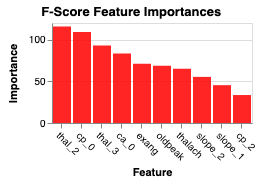

In [18]:
plot_importance(best_Features_Fscore, fs_importance, "F-Score", "red")

According to the F-Scores, the highest F-Score was thal_2, which refers to a fixed defect. This is followed by a chest pain value of 0 (cp_0) which refers to a typical angina, and then followed by thal_3 (which refers to a reversable defect). As a side note, all the features refer to an aspect of the chest or heart in some capacity.

### Data Train and Test Splitting

The original dataset contains 303 values, which isn't a lot, therefore we shall use all 303 rows for the train and test split. We will also use a 70:30 ratio for the train and test split.

In [19]:
heart_sample = pd.DataFrame(heart).values
target_sample = pd.DataFrame(target).values

print(heart_sample.shape)
print(target_sample.shape)

(303, 26)
(303, 1)


In [20]:
from sklearn.model_selection import train_test_split

heart_train, heart_test, \
target_train, target_test = train_test_split(heart_sample, target_sample, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_sample)

print(heart_train.shape)
print(heart_test.shape)

(212, 26)
(91, 26)


### Model Evaluation Strategy

We will train and tune our data on the 212 rows and test it against 91 rows. 

For each model we will also used a 5 fold stratified cross-validation. The stratified cross validation will help in making sure each fold is a representative of the whole <cite data-cite = 'CrossVal'>(Kohavi, 1995)</cite>. Stratification is generally a better scheme when dealing with variance and bias compared to regular cross validation.

In [21]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cross_val_method = StratifiedKFold(n_splits=5, random_state=999)

<a id ='Hyper'></a>

# Hyperparameter Tuning


## K-Nearest Neighbour (KNN)

Using a pipeline, I will conduct a grid search to find the best features for KNN. I will tune the hyperparameters on:

* Number of Neighbours (`n_neighbours`)
* p (Manhatten, Euclidean and Minkowski)

Similar usages of a Pipeline will be used on subsequent models.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline([('fselector', fs.SelectKBest()), 
                     ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'fselector__k': [5,10, 20, heart.shape[1]],
                   'knn__n_neighbors': [1, 5, 10, 15, 20, 25, 30 ,35, 40, 60],
                   'knn__p': [1, 2, 3, 4, 5]}
 
GridSearch_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cross_val_method,
                           scoring='roc_auc',
                           verbose=1) 


In [23]:
GridSearch_KNN.fit(heart_train, target_train);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    9.0s finished


In [24]:
GridSearch_KNN.best_params_

{'fselector__k': 20, 'knn__n_neighbors': 40, 'knn__p': 4}

In [25]:
GridSearch_KNN.best_score_

0.9174871011614352

We observe that the best parameters for the KNN are 20 features, 40 neighbours and p = 4. This gives an AUC score ~0.917.

Below is a custom function from <cite data-cite= 'Custom'>(Vural, 2019)</cite>, this function will get the search results of a pipeline and convert it into a pandas dataframe

In [26]:
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [27]:
KNN_results = get_search_results(GridSearch_KNN)
KNN_results.head()

,mean_score,std_score,max_score,min_score,fselector__k,knn__n_neighbors,knn__p
143,0.917265,0.050176,0.981693,0.842105,20.0,40.0,4.0
144,0.917025,0.050731,0.981693,0.840961,20.0,40.0,5.0
199,0.916716,0.046086,0.983982,0.856979,26.0,60.0,5.0
198,0.916487,0.046299,0.983982,0.856979,26.0,60.0,4.0
197,0.916476,0.047372,0.985126,0.853547,26.0,60.0,3.0


We observe that the best grid search results all contain 20 or more features with a p value refering to a Minkowski distance parameter. 

The below function allows us to visualise the grid search based on the number of features entered.

In [28]:
import altair as alt

def plot_GS_KNN(number_features):
    results_KNN_x_features = KNN_results[KNN_results['fselector__k'] == number_features]

    chart = alt.Chart(results_KNN_x_features, height = 100, width = 150,
          title='KNN Performance Comparison with ' + str(number_features) + " Features"
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Number of Neighbors'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('knn__p:N', title='p')
    )
    return chart


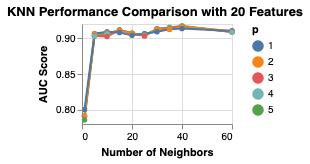

In [29]:
plot_GS_KNN(20)

We observe that the KNN performance with 40 neighbours had overall better results. We also observe that the p value distribitions are very similar in both cases.

## (Gaussian) Naive Bayes (NB)

For the Gaussian Naive Bayes model, we want to optimise var_smoothing. To do this I used a NumPy logspace of 10, to 10 to the power of -2, with 200 different values. To meet the requirements of a Gaussian distribution, I need to first perform a power transformation on the train data before fitting the model.

In [30]:
from sklearn.preprocessing import PowerTransformer
heart_train_transformed = PowerTransformer().fit_transform(heart_train)

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('fselector', fs.SelectKBest()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'fselector__k': [5,10, 20, heart.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-2, num=200)}


gs_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cross_val_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_NB.fit(heart_train_transformed, target_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    1.3s finished


In [32]:
gs_NB.best_params_

{'nb__var_smoothing': 6.368249944718588, 'fselector__k': 26}

In [33]:
gs_NB.best_score_

0.9158693493372478

We observe the optimal parameters of the Gaussian NB model yields an AUC score of ~0.916 with a var_smoothing value of ~6.83. This however, is using all 26 features. This however looks as though it doesn't perform as well as the KNN which had a slightly higher score. This will be tested later on to see if each score are significantly different from one another.

In [34]:
results_NB = get_search_results(gs_NB)
results_NB.head()

,mean_score,std_score,max_score,min_score,nb__var_smoothing,fselector__k
0,0.915606,0.051768,0.979405,0.846682,6.368250,26.0
5,0.909497,0.053062,0.981693,0.846682,2.673842,26.0
3,0.903593,0.052762,0.977117,0.842105,0.977124,20.0
4,0.900069,0.054924,0.967963,0.812357,0.027364,10.0
8,0.900023,0.054291,0.967963,0.816934,0.130490,10.0


We observe that all 26 features yield the best result for this model. However 20 features yield a score slightly less than the best parameter score. 

Below is a function to plot the distribution of var_smoothing with the AUC score, with the input being the number of features you want to visualise.

In [35]:
def plot_GS_NB(number_features):
    results_NB_x_features = results_NB[results_NB['fselector__k'] == number_features]

    chart = alt.Chart(results_NB_x_features,height = 100, width = 150,
          title='NB Performance Comparison with ' + str(number_features) + " Features"
         ).mark_line(point=True).encode(
    alt.X('nb__var_smoothing', title='Var. Smoothing'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    )
    return chart


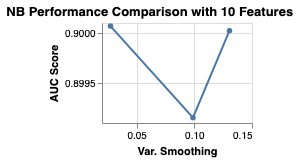

In [36]:
plot_GS_NB(10)

## Bernoulli NB

In this section I will look at fitting a Bernoulli Naive Bayes (NB) model to this data. For Bernoulli NB, features are assumed independant boolean/binary variables which describe the input. Assuming all features are independant, we will begin to build this model by transforming the original data set into a set of binary variables. For this, we could either take the non-binary variables and bin them, for example, we could bin age into age group columns and give a binary 0 or 1 if a patient falls into that age group, or we could take away all the variables that are not binary. In this case we will do both by removing any non-binary variables and re-training the model and also binning all continous variables into binary columns. Since the target column is binary we do not have to binarize this column.

### Removing Non-Binary Features

In this section I will remove the non-binary features and run a Bernoulli NB model on only the binary features

In [37]:
from sklearn.naive_bayes import BernoulliNB

In [38]:
# Check for binary values
heart_copy.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_0,cp_1,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
1.0,63,1,145.0,233.0,1,150.0,0,2.3,0,0,...,0,0,1,0,0,0,0,1,0,0
2.0,37,1,130.0,250.0,0,187.0,0,3.5,0,0,...,0,0,1,0,0,0,0,0,1,0
3.0,41,0,130.0,204.0,0,172.0,0,1.4,0,1,...,0,1,1,0,0,0,0,0,1,0
4.0,56,1,120.0,236.0,0,178.0,0,0.8,0,1,...,0,1,1,0,0,0,0,0,1,0
5.0,57,0,120.0,354.0,0,163.0,1,0.6,1,0,...,0,1,1,0,0,0,0,0,1,0


Drop all non-binary variables

In [39]:
heart_B = heart_copy.drop(['age', 'trestbps','chol','thalach', 'oldpeak'], axis=1)

Now we need to re-train a model as we have changed the dataframe

In [40]:
heart_B_sample = pd.DataFrame(heart_B).values
target_B_sample = pd.DataFrame(target).values

print(heart_B_sample.shape)
print(target_B_sample.shape)

(303, 21)
(303, 1)


In [41]:
heart_B_train, heart_B_test, \
target_B_train, target_B_test = train_test_split(heart_B_sample, target_B_sample, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_sample)
print(heart_B_train.shape)
print(heart_B_test.shape)

(212, 21)
(91, 21)


In [42]:
pipe_b_NB = Pipeline([('fselector', fs.SelectKBest()), 
                     ('b_NB', BernoulliNB(binarize = None))])

params_pipe_b_NB = {'fselector__k': [5, 10, 15, 20, heart_B.shape[1]]}

gs_b_NB = RandomizedSearchCV(estimator=pipe_b_NB, 
                          param_distributions=params_pipe_b_NB, 
                          cv=cross_val_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_b_NB.fit(heart_B_train, target_B_train);


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:    0.1s finished


In [43]:
gs_b_NB.best_params_

{'fselector__k': 21}

In [44]:
gs_b_NB.best_score_

0.920098441345365

We observe that all 21 features yield the best results for this model, with an AUC score of 0.92

In [45]:
results_b_NB = get_search_results(gs_b_NB)
results_b_NB.head()

,mean_score,std_score,max_score,min_score,fselector__k
4,0.920000,0.044110,0.986270,0.862700,21.0
3,0.917757,0.045337,0.986270,0.862700,20.0
2,0.915057,0.044119,0.979405,0.853547,15.0
1,0.912014,0.043745,0.973684,0.839817,10.0
0,0.865435,0.053362,0.947368,0.779176,5.0


We observe that 10 or more features produces a relatively similar score to models with more features. With the 10 feature mean score at ~0.91 and the best having a score of 0.92. This model seems to be the best model so far, producing a result better than both previous models.

This function will let us visualise both results.

In [46]:
def plot_GS_b_NB(results):

    chart = alt.Chart(results, height = 100, width = 150,
          title='Bernoulli NB Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('fselector__k', title='Features'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    )
    return chart

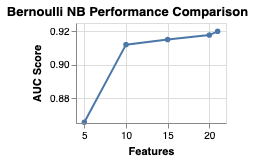

In [47]:
plot_GS_b_NB(results_b_NB)

This distribution shows us that the score basically plateaus after 10 features, with incremental performance gains as the number of features goes increases.

### Binning Continuous Values

In this section I will make a new dataframe that will bin all the continuous variables and parse them as a 0 or 1 if they fit into that category. First I will bin the values, then I will make dummies of these values and drop the real column. The values I need to make bins for are: age, trestbps, chol, thalach and oldpeak. To make the bins for these columns, I looked at their summary statistics and determined a suitable number of bins.

In [48]:
heart_bin_B = heart_copy

In [49]:
heart_bin_B['age'].describe()

count    303.000000
mean      54.366337
std        9.082101
min       29.000000
25%       47.500000
50%       55.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

In [50]:
# Set up bins variables
heart_bin_B['age_bins'] = pd.cut(heart_bin_B['age'], 5)

In [51]:
heart_bin_B['trestbps'].describe()

count    303.000000
mean     131.623762
std       17.538143
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

In [52]:
heart_bin_B['trestbps_bins'] = pd.cut(heart_bin_B['trestbps'], 5)

In [53]:
heart_bin_B['chol'].describe()

count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: chol, dtype: float64

In [54]:
heart_bin_B['chol_bins'] = pd.cut(heart_bin_B['chol'], 5)

In [55]:
heart_bin_B['thalach'].describe()

count    303.000000
mean     149.646865
std       22.905161
min       71.000000
25%      133.500000
50%      153.000000
75%      166.000000
max      202.000000
Name: thalach, dtype: float64

In [56]:
heart_bin_B['thalach_bins'] = pd.cut(heart_bin_B['thalach'], 5)

In [57]:
heart_bin_B['oldpeak'].describe()

count    303.000000
mean       1.039604
std        1.161075
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64

In [58]:
heart_bin_B['oldpeak_bins'] = pd.cut(heart_bin_B['oldpeak'], 4)

Now we will make dummies of these columns and drop the original continuous columns

In [59]:
heart_bin_B = pd.get_dummies(heart_bin_B)
heart_bin_B = heart_bin_B.drop(['age', 'trestbps','chol','thalach', 'oldpeak'], axis=1)

Now we will re run the Bernoulli Naive Bayes Classifier to see if our results have gotten better. First we must re-train the model as we have changed the dataframe

In [60]:
heart_B_bins = pd.DataFrame(heart_bin_B).values
target_B_bins = pd.DataFrame(target).values

print(heart_B_bins.shape)
print(target_B_bins.shape)

(303, 45)
(303, 1)


In [61]:
heart_B_bin_train, heart_B_bin_test, \
target_B_bin_train, target_B_bin_test = train_test_split(heart_B_bins, target_B_bins, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_sample)
print(heart_B_bin_train.shape)
print(heart_B_bin_test.shape)

(212, 45)
(91, 45)


In [62]:
pipe_b_bins_NB = Pipeline([('fselector', fs.SelectKBest()), 
                     ('b_NB', BernoulliNB(binarize = None))])

params_pipe_b_bins_NB = {'fselector__k': [5, 10, 15, 20, 25, 30, 35, 40, heart_B.shape[1]]}

gs_b_NB_binned = RandomizedSearchCV(estimator=pipe_b_bins_NB, 
                          param_distributions=params_pipe_b_bins_NB, 
                          cv=cross_val_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_b_NB_binned.fit(heart_B_bin_train, target_B_bin_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:    0.2s finished


In [63]:
gs_b_NB_binned.best_params_

{'fselector__k': 40}

In [64]:
gs_b_NB_binned.best_score_

0.9140683692413972

Binning the values didn't seem to give us a better classifier than the one before. In fact the top test result was lower than the non-binned one. Indicating that they didn't improve the overall score of the for this model.

In [65]:
results_b__binned_NB = get_search_results(gs_b_NB_binned)
results_b__binned_NB.head()

,mean_score,std_score,max_score,min_score,fselector__k
7,0.913799,0.060516,0.990847,0.823799,40.0
4,0.912288,0.052352,0.979405,0.836384,25.0
5,0.911808,0.056426,0.983982,0.829519,30.0
8,0.910801,0.057641,0.979405,0.824943,21.0
6,0.909085,0.062169,0.988558,0.815789,35.0


For this version of the Bernoulli NB model, we observe that the classifier seems to be a bit less sensitive to the number of features, unlike previous models. 

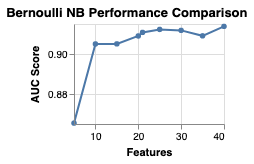

In [66]:
plot_GS_b_NB(results_b__binned_NB)

This distribution is vastly different from the previous distribution, as we observe that the number of features doesn't always indicate how well the model performs.

## Decision Tree (DT)

We want to build a Decision Tree to maximise the information gain. We will look to see which criterion, gini or entropy will give us the best result. To do this we will pipe in different values for these parameters in order to determine the best set of values. We will also look into different values for max_depth and min_samples_split, to find the best hyperparameters for this model.

In [67]:
from sklearn.tree import DecisionTreeClassifier

In [68]:
DT_pipe = Pipeline([('fselector', fs.SelectKBest()), 
                     ('DT', DecisionTreeClassifier())])

DT_pipe_params = {'fselector__k' : [5, 10, 15, 20,  heart.shape[1]],
                  'DT__criterion': ['entropy', 'gini'],
                 'DT__max_depth' : [2,3,5,9,10],
                 'DT__min_samples_split' : [2,3,5,10,50,100]}

GridSearch_DT = GridSearchCV(estimator=DT_pipe, 
                          param_grid=DT_pipe_params, 
                          cv=cross_val_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=0) 

In [69]:
GridSearch_DT.fit(heart_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x1a2567cd08>)), ('DT', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [5, 10, 15, 20, 26], 'DT__criterion': ['entropy', 'gini'], 'DT__max_depth': [2, 3, 5, 9, 10], 'DT__min_samples_split': [2, 3, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [70]:
GridSearch_DT.best_params_

{'DT__criterion': 'entropy',
 'DT__max_depth': 5,
 'DT__min_samples_split': 50,
 'fselector__k': 20}

In [71]:
GridSearch_DT.best_score_

0.8630726220802211

We observe that the best parameters are the criterion being entropy, max_depth = 5, min_samples_split = 50, all based on the 20 best features as selected by their f score. This yielded an AUC score of ~0.86, which is much worse than the previous models.

In [72]:
results_DT = get_search_results(GridSearch_DT)
results_DT.head()

,mean_score,std_score,max_score,min_score,DT__criterion,DT__max_depth,DT__min_samples_split,fselector__k
83,0.8627,0.0783921,0.929062,0.710526,entropy,5,50,20
48,0.861178,0.0631719,0.911957,0.741419,entropy,3,10,20
47,0.861178,0.0631719,0.911957,0.741419,entropy,3,10,15
32,0.861178,0.0631719,0.911957,0.741419,entropy,3,2,15
43,0.861178,0.0631719,0.911957,0.741419,entropy,3,5,20


From the table we can observe that the best criterion was always entropy, with the min_sample_spit seeming to play a big role in determining the best DT, as its values are quite erratic. the F-score selector was constantly above 15.

Below we visualise the results on how to the model performed based on both the max_depth and the criterion, given the number of features as an input.

In [73]:
def plot_DT_MaxDepth(number_of_features):
    results_DT_x_features = results_DT[results_DT['fselector__k'] == number_of_features]

    chart = alt.Chart(results_DT_x_features, height = 100, width = 150, 
          title='DT Performance Comparison with ' + str(number_of_features) +' Features'
             ).mark_line(point=True).encode(
        alt.X('DT__min_samples_split', title='Min Samples for Split'),
        alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
        alt.Color('DT__max_depth:N', title='Max Depth')
    )
    return chart

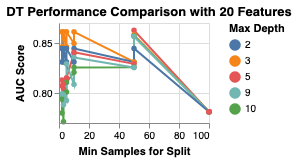

In [74]:
plot_DT_MaxDepth(20)

In [75]:
def plot_DT_Cr(number_of_features):
    results_DT_x_features = results_DT[results_DT['fselector__k'] == number_of_features]

    chart = alt.Chart(results_DT_x_features, height = 100, width = 150,
          title='DT Performance Comparison with ' + str(number_of_features) +' Features'
             ).mark_line(point=True).encode(
        alt.X('DT__min_samples_split', title='Min Samples for Split'),
        alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
        alt.Color('DT__criterion')
    )
    return chart

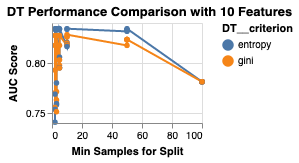

In [76]:
plot_DT_Cr(10)

## Regression Modelling

In this section I will look into finding a suitable regression model for this data. Since the target is binary I will look into a logistic regression model. First I will fit a full model, use all predictors, then I will look into the model and see if I can make a simpler model. 
Firstly I tuned the parameters based on l1 and l2. Both of these metrics are based on preventing overfitting. I will also use these metrics when modelling the simple logistic regression model.

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
lr_pipe = Pipeline([('fselector', fs.SelectKBest()), 
                     ('lr', LogisticRegression())])

lr_pipe_params = {'fselector__k' : [5, 10, 15, 20,  heart.shape[1]],
                 'lr__penalty' : ['l1','l2']}

GridSearch_lr = GridSearchCV(estimator=lr_pipe, 
                          param_grid=lr_pipe_params, 
                          cv=cross_val_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

In [79]:
GridSearch_lr.fit(heart_train,target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x1a2567cd08>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [5, 10, 15, 20, 26], 'lr__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [80]:
GridSearch_lr.best_params_

{'fselector__k': 20, 'lr__penalty': 'l2'}

In [81]:
GridSearch_lr.best_score_

0.9165337204783904

We observe that the best parameters are l2 and 20 features. This gives us an AUC score of ~0.917. This model seems to perform the same as the KNN model.

In [82]:
results_lr = get_search_results(GridSearch_lr)
results_lr.head()

,mean_score,std_score,max_score,min_score,fselector__k,lr__penalty
7,0.916453,0.047193,0.990847,0.846682,20,l2
9,0.915904,0.0476916,0.988558,0.846682,26,l2
5,0.914211,0.047687,0.988558,0.842105,15,l2
8,0.913684,0.050665,0.98627,0.832952,26,l1
6,0.912403,0.050155,0.98627,0.832952,20,l1


From the table, we can observe that 15 features nearly gives us the same result as the 20 feature model.

The below visualisation allow us to see how the score changes based on the penalty (l1 or l2).

In [83]:
def plot_lr(results):
    chart = alt.Chart(results, height = 100, width = 150,
          title='Logistic Regression Performance'
             ).mark_line(point=True).encode(
        alt.X('fselector__k', title='Number of Features'),
        alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
        alt.Color('lr__penalty')
    )
    return chart

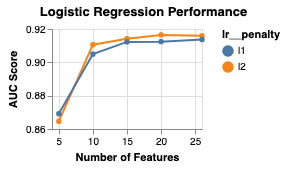

In [84]:
plot_lr(results_lr)

### Simplest Model

Now that we have a model built by sklearn we will see what the model looks like. From here, we can see the p values and make decisions about what to cut out and what to leave in. Firstly, I will take the binned data set that I created for the bernoulli NB and change the column names. This was done as the 'glm' function doesn't parse any column with ']' in it. I will then start fitting models and iteratively making them simpler. I will also make a dummy of the target variable in order to predict whether it is heart disease (target = 1).

In [85]:
heart_lr = heart_bin_B.copy()
heart_lr = heart_lr.rename(columns={'age_bins_(28.952, 38.6]' : 'age0', 'age_bins_(38.6, 48.2]' : 'age1',
                                   'age_bins_(48.2, 57.8]' : 'age2', 'age_bins_(57.8, 67.4]' : 'age3',
       'age_bins_(67.4, 77.0]': 'age4', 'trestbps_bins_(93.894, 115.2]' : 'trest0',
       'trestbps_bins_(115.2, 136.4]' : 'trest1', 'trestbps_bins_(136.4, 157.6]' : 'trest2',
       'trestbps_bins_(157.6, 178.8]' : 'trest3', 'trestbps_bins_(178.8, 200.0]' : 'trest4',
       'chol_bins_(125.562, 213.6]' : 'chol0', 'chol_bins_(213.6, 301.2]' : 'chol1',
       'chol_bins_(301.2, 388.8]' : 'chol2', 'chol_bins_(388.8, 476.4]' : 'chol3',
       'chol_bins_(476.4, 564.0]' : 'chol4', 'thalach_bins_(70.869, 97.2]' : 'thalach0',
       'thalach_bins_(97.2, 123.4]' : 'thalach1', 'thalach_bins_(123.4, 149.6]' : 'thalach2',
       'thalach_bins_(149.6, 175.8]' : 'thalach3', 'thalach_bins_(175.8, 202.0]' : 'thalach4',
       'oldpeak_bins_(-0.0062, 1.55]' : 'old0', 'oldpeak_bins_(1.55, 3.1]' : 'old1',
       'oldpeak_bins_(3.1, 4.65]' : 'old2', 'oldpeak_bins_(4.65, 6.2]' : 'old3'
    
})
dummies = pd.get_dummies(target)
heart_lr['target1'] = dummies['1']

Now that we've changed all the column names we can now start iteratively building a simple logistic regression model.

In [86]:
heart_lr.columns

Index(['sex', 'fbs', 'exang', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0',
       'restecg_1', 'restecg_2', 'slope_0', 'slope_1', 'slope_2', 'ca_0',
       'ca_1', 'ca_2', 'ca_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'age0',
       'age1', 'age2', 'age3', 'age4', 'trest0', 'trest1', 'trest2', 'trest3',
       'trest4', 'chol0', 'chol1', 'chol2', 'chol3', 'chol4', 'thalach0',
       'thalach1', 'thalach2', 'thalach3', 'thalach4', 'old0', 'old1', 'old2',
       'old3', 'target1'],
      dtype='object')

We first start out trying to fit a full model. This was done using statsmodels package.

In [87]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
mylogit = smf.glm(formula='target1 ~  sex + fbs + exang + cp_0 + cp_1 + cp_2 + cp_3 + restecg_0 + restecg_1 + restecg_2 + slope_0 + slope_1 + slope_2 + ca_0 + ca_1 + ca_2 + ca_3 + thal_0 + thal_1 + thal_2 + thal_3 + age0 + age1 + age2 + age3 + age4 + trest0 + trest1 + trest2 + trest3 + trest4 + chol0 + chol1 + chol2 + chol3 + chol4 + thalach0 + thalach1 + thalach2 + thalach3 + thalach4 + old0 + old1 + old2 + old3', data=heart_lr, family=sm.families.Binomial())
print(mylogit.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                target1   No. Observations:                  303
Model:                            GLM   Df Residuals:                      267
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 07 Jun 2019   Deviance:                          nan
Time:                        12:19:41   Pearson chi2:                 2.43e+17
No. Iterations:                   100   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -4.14e+14   8.29e+06     -5e+07      0.000   -4.14e+14   -4.14e+14
sex        -3.471e+14   1.01e+07  -3.44e+07      0.0

Although all the p-values are 0, we see errors in the chi squared, AIC and BIC, giving a NAN value. Therefore, we must simplify this model.

In order to simplify this model, I will first look at modelling just the categorical features, then reinserting the binned features later on.

In [88]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
mylogit = smf.glm(formula='target1 ~  sex + fbs + exang + cp_0 + cp_1 + cp_2 + cp_3 + restecg_0 + restecg_1 + restecg_2 + slope_0 + slope_1 + slope_2 + ca_0 + ca_1 + ca_2 + ca_3 + thal_0 + thal_1 + thal_2 + thal_3', data=heart_lr, family=sm.families.Binomial())
print(mylogit.fit().summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            230.4432  
Link Function:      logit            BIC:            -1437.6844
Dependent Variable: target1          Log-Likelihood: -98.222   
Date:               2019-06-07 12:19 LL-Null:        -208.82   
No. Observations:   303              Deviance:       196.44    
Df Model:           16               Pearson chi2:   382.      
Df Residuals:       286              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   -0.0309    0.4373  -0.0706  0.9437  -0.8880   0.8263
sex         -1.4659    0.4924  -2.9772  0.0029  -2.4309  -0.5008
fbs          0.2921    0.5411   0.5399  0.5893  -0.7684   1.3527
exang       -0.9431    0.4222  -2.2337  0.0255  -

From the above table we can see that fbs, cp_1, cp_3, all of restecg, slope_0, slope_1, ca_1, ca_3 and all of thal are insignificant at alpha = 0.05. Therefore we will remove them and fit a simpler model

In [89]:
heart_lr1 = heart_lr.copy()
heart_lr1 = heart_lr1.drop(['fbs','cp_1','cp_3','restecg_0','restecg_2','slope_0','ca_1', 'ca_3','thal_0','thal_1','thal_2','thal_3'], axis = 1)

In [90]:
mylogit = smf.glm(formula='target1 ~  sex + exang + cp_0 + cp_2 + slope_1 + slope_2 + ca_0 + ca_2', data=heart_lr1, family=sm.families.Binomial())
print(mylogit.fit().summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            235.4467  
Link Function:      logit            BIC:            -1462.3908
Dependent Variable: target1          Log-Likelihood: -108.72   
Date:               2019-06-07 12:19 LL-Null:        -208.82   
No. Observations:   303              Deviance:       217.45    
Df Model:           8                Pearson chi2:   309.      
Df Residuals:       294              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept    0.8012    0.8225   0.9741  0.3300  -0.8109   2.4133
sex         -1.7984    0.4118  -4.3667  0.0000  -2.6056  -0.9912
exang       -1.1365    0.3925  -2.8958  0.0038  -1.9058  -0.3673
cp_0        -1.7565    0.4433  -3.9623  0.0001  -

I will now remove cp_2, slope_1, ca_2 as their p values are greater than 0.05.

Now that I know what categorical variables, I will iteratively reinsert other variables. To judge whether or not the model is performing better I will look at the AIC and BIC. A lower AIC and BIC mean a better model. I will do this in one step.

In [91]:
mylogit = smf.glm(formula='target1 ~  sex + exang + cp_0  + slope_2 + ca_0', data=heart_lr1, family=sm.families.Binomial())
print(mylogit.fit().summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            232.2301  
Link Function:      logit            BIC:            -1476.7485
Dependent Variable: target1          Log-Likelihood: -110.12   
Date:               2019-06-07 12:19 LL-Null:        -208.82   
No. Observations:   303              Deviance:       220.23    
Df Model:           5                Pearson chi2:   317.      
Df Residuals:       297              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept    0.5913    0.4473   1.3219  0.1862  -0.2854   1.4680
sex         -1.7265    0.4016  -4.2992  0.0000  -2.5136  -0.9394
exang       -1.1018    0.3886  -2.8350  0.0046  -1.8635  -0.3401
cp_0        -1.9848    0.3679  -5.3953  0.0000  -

The model without had an AIC of ~232, whereas this new model had an AIC of 229 indicating a better model. Every other binned predictor (besides age3) was not significant to 5%. 

However when the model with age3 was tested, the overall model was not adequate to 5%, as the defined by: 
 H0: the model fits the data well vs.
 H1: the model does not fit the data well

The p-value = 0.04669, therefore the logistic model for this data can not be used to predict the probability of having heart disease given these predictors. Therefore, we will leave out 'age3'

The simplest model is defined as (where hd = heart disease):
hd = 1.0814 + -1.7265SEX - 1.1018EXANG - 1.9848CP_0 + 1.7879SLOPE_2 + 2.2810CA_0

From the model we can conduct a chi-squared test to see whether the model is adequet with the same hypothesis test used before.
We can see that the residual deviance is ~215.00 on 296 degrees of freedom.
The p value of the chi-square test is equals 0.2032, indicating that the null hypothesis is plausible, therefore
we can conclude that the logistic model is significantly adequate.

This means that a logistic model for this data can be used to predict the probability of having heart disease given these
predictors.


In [92]:
target1 = heart_lr1['target1']
heart_lr1 = heart_lr1.drop(['target1', 'cp_2', 'restecg_1', 'slope_1',
        'ca_2', 'age0', 'age1', 'age2', 'age3', 'age4', 'trest0',
       'trest1', 'trest2', 'trest3', 'trest4', 'chol0', 'chol1', 'chol2',
       'chol3', 'chol4', 'thalach0', 'thalach1', 'thalach2', 'thalach3',
       'thalach4', 'old0', 'old1', 'old2', 'old3'], axis = 1)


In [93]:
heart_lr_sample = pd.DataFrame(heart_lr1).values
target_lr_sample = pd.DataFrame(target1).values

print(heart_lr_sample.shape)
print(target_lr_sample.shape)

(303, 5)
(303, 1)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(heart_lr_sample, target_lr_sample, test_size=0.3, random_state=0)

In [95]:
lr_simple_pipe = Pipeline([('fselector', fs.SelectKBest()), 
                     ('lr', LogisticRegression())])

lr_simple_pipe_params = {'fselector__k' : [1,2,3, heart_lr1.shape[1]],
                 'lr__penalty' : ['l1','l2']}

GridSearch_lr_simple = GridSearchCV(estimator=lr_simple_pipe, 
                          param_grid=lr_simple_pipe_params, 
                          cv=cross_val_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 
GridSearch_lr_simple.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('fselector', SelectKBest(k=10, score_func=<function f_classif at 0x1a2567cd08>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'fselector__k': [1, 2, 3, 5], 'lr__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [96]:
GridSearch_lr_simple.best_params_

{'fselector__k': 5, 'lr__penalty': 'l2'}

In [97]:
GridSearch_lr_simple.best_score_

0.8980374845885565

We observe a near similar result to the full regression model in terms of AUC score. Although smaller, this model is only using 5 predictors.

In [98]:
results_s_lr = get_search_results(GridSearch_lr_simple)
results_s_lr.head()

,mean_score,std_score,max_score,min_score,fselector__k,lr__penalty
7,0.897925,0.0360703,0.951754,0.841009,5,l2
6,0.893424,0.0373262,0.951754,0.836623,5,l1
4,0.86401,0.0346206,0.908991,0.811213,3,l1
5,0.858899,0.0480232,0.917763,0.776888,3,l2
3,0.807221,0.0646012,0.879386,0.715103,2,l2


From the table we can observe that the best model was a based on all 5 features and a penalty of l2. The max score of the top model was ~0.95, which is, considering the previous models high feature count, is quite remarkable.

Below is a visualisation of the score vs the number of features.

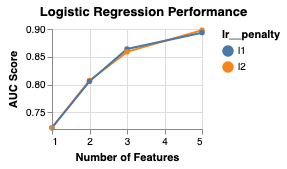

In [99]:
plot_lr(results_s_lr)

<a id='Per'></a>

# Performance Comparison

The classification models proposed have been optimised on the training data. For comparison, I will be doing a pairwise t-test in order to dicern which model performs the best. Due to the randomness of the cross validation, I will be doing a stratified 10 fold cross validation on each model to find the mean score before testing each model. The first round will consist of both Naive Bayes models and both logistic regression models. The better of the two will then be compared to KNN, DT and eachother. The tests will be as follows:

The first round will consist of:

* Bernoulli NB vs Gaussian NB
* Simplified Logistic Regression vs Full Logistic Regression

The winner of those tests will then be compared to KNN and DT. For these tests, assume the winners of the first round are B and C.

* KNN vs B
* KNN vs C
* C vs B
* KNN vs DT
* DT vs C
* DT vs B


In [100]:
from sklearn.model_selection import cross_val_score

ttest_cv = StratifiedKFold(n_splits=10, random_state=1)


In [101]:
results_b_NB_cv = cross_val_score(estimator=gs_b_NB.best_estimator_,
                                 X=heart_test,
                                 y=target_test, 
                                 cv=ttest_cv, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
results_b_NB_cv.mean()

0.932

In [102]:
heart_test_transformed = PowerTransformer().fit_transform(heart_test)

results_NB_cv = cross_val_score(estimator=gs_NB.best_estimator_,
                                 X=heart_test_transformed,
                                 y=target_test, 
                                 cv=ttest_cv, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
results_NB_cv.mean()

0.9349999999999999

In [103]:
results_s_lr_cv = cross_val_score(estimator=GridSearch_lr_simple.best_estimator_,
                                 X=heart_test,
                                 y=target_test, 
                                 cv=ttest_cv, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
results_s_lr_cv.mean()

0.9275

In [104]:
results_LR_cv = cross_val_score(estimator=GridSearch_lr.best_estimator_,
                                 X=heart_test,
                                 y=target_test, 
                                 cv=ttest_cv, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
results_LR_cv.mean()

0.96

In [105]:
results_DT_cv = cross_val_score(estimator=GridSearch_DT.best_estimator_,
                                 X=heart_test,
                                 y=target_test, 
                                 cv=ttest_cv, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
results_DT_cv.mean()

0.8325000000000001

In [106]:
results_KNN_cv = cross_val_score(estimator=GridSearch_KNN.best_estimator_,
                                 X=heart_test,
                                 y=target_test, 
                                 cv=ttest_cv, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
results_KNN_cv.mean()

0.9189999999999999

Since the random state is constant, each of the test sets are fixed, therefore we can run paired t-tests accurately. I will run these paired t-tests to determine the best model according to their AUC score.

In [107]:
from scipy import stats
# round 1
print("t-test for Bernoulli NB vs Gaussian NB: \n" + str(stats.ttest_rel(results_b_NB_cv, results_NB_cv)) + "\n")
print("t-test for simple logistic regression vs full logistic regression: \n" + str(stats.ttest_rel(results_LR_cv, results_s_lr_cv)))

t-test for Bernoulli NB vs Gaussian NB: 
Ttest_relResult(statistic=-0.20751433915982262, pvalue=0.840227666913529)

t-test for simple logistic regression vs full logistic regression: 
Ttest_relResult(statistic=2.326544946460383, pvalue=0.045000997712527385)


The Naive Bayes Models were not significantly different from one another as indicted by their p values being above 0.05. The Simple Logistic Regression model and the Full Logistic Regression Model however, are significantly different at 5% (p < 0.05). Therefore I will continue with the Full Logistic Regression Model. Either Naive Bayes model would be fine to continue with as they are not significantly different so I will continue with the Bernoulli Naive Bayes model.

In [108]:
# round 2:
print("KNN vs DT: \n" + str(stats.ttest_rel(results_KNN_cv, results_DT_cv)) + "\n")
print("KNN vs Logistic Regression: \n" +str(stats.ttest_rel(results_KNN_cv, results_LR_cv))+ "\n")
print("Logistic Regression vs Bernoulli Naive Bayes: \n" +str(stats.ttest_rel(results_LR_cv, results_b_NB_cv))+ "\n")
print("KNN vs Bernoulli NB: \n" +str(stats.ttest_rel(results_KNN_cv, results_b_NB_cv))+ "\n")
print("DT vs Logistic Regression: \n" +str(stats.ttest_rel(results_DT_cv, results_LR_cv))+ "\n")
print("DT vs Bernoulli NB: \n" +str(stats.ttest_rel(results_DT_cv, results_b_NB_cv))+ "\n")

KNN vs DT: 
Ttest_relResult(statistic=4.440441083862264, pvalue=0.0016224595212309051)

KNN vs Logistic Regression: 
Ttest_relResult(statistic=-1.9438290893161172, pvalue=0.08379281305897199)

Logistic Regression vs Bernoulli Naive Bayes: 
Ttest_relResult(statistic=1.9498010508590446, pvalue=0.08299322957614211)

KNN vs Bernoulli NB: 
Ttest_relResult(statistic=-0.8518614552445126, pvalue=0.4163818598080866)

DT vs Logistic Regression: 
Ttest_relResult(statistic=-4.437113147827923, pvalue=0.001630287900503843)

DT vs Bernoulli NB: 
Ttest_relResult(statistic=-5.3378090647717436, pvalue=0.0004698268438594737)



Most of these models differ to 5% significance, with the exception of KNN vs Bernoulli NB, Logistic Regression vs KNN and Logistic Regression vs Bernoulli NB. Since the Logistic Regression model is significantly different to both these models at 10% as p < 0.1, We can conclude with 90% accuracy that the Full Logistic Regression Model is statistically the best model when compared to the test data and in terms of AUC score.

Since this method used the AUC to optimize hyperparameters, we will also take into consideration other factors to dicern the best model. To do this, I will be using sklearns classification report to look at:

* Accuracy
* Precision
* Recall
* F1 Score

I will also be looking at each models confusion matrix

To do this I will use the predict function from every grid search in order to obtain the results

In [109]:
# KNN 
KNN_pred = GridSearch_KNN.predict(heart_test)

In [110]:
# Gaussian NB
G_NB_pred = gs_NB.predict(heart_test_transformed)

In [111]:
# Bernoulli NB
B_NB_pred = gs_b_NB.predict(heart_B_test)

In [112]:
# DT
pred_DT = GridSearch_DT.predict(heart_test)

In [113]:
# Simple Logistic Regression
pred_S_LR = GridSearch_lr_simple.predict(X_test)

In [114]:
# Full Logistic Regression
pred_FullLR = GridSearch_lr.predict(heart_test)

In [115]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_test, KNN_pred))
print("\nClassification report for Gaussian Naive Bayes") 
print(metrics.classification_report(target_test, G_NB_pred))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(target_test, pred_DT))
print("\nClassification report for Simple Logistic Regression") 
print(metrics.classification_report(y_test, pred_S_LR))
print("\nClassification report for Full Logistic Regression") 
print(metrics.classification_report(target_test, pred_FullLR))
print("\nClassification report for Bernoulli NB") 
print(metrics.classification_report(target_test, B_NB_pred))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        41
           1       0.84      0.92      0.88        50

   micro avg       0.86      0.86      0.86        91
   macro avg       0.86      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91


Classification report for Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        41
           1       0.82      0.92      0.87        50

   micro avg       0.85      0.85      0.85        91
   macro avg       0.85      0.84      0.84        91
weighted avg       0.85      0.85      0.84        91


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        41
           1       0.75      0.66      0.70        50

   micro avg       0.69      0.69      0.69    

In [116]:
from sklearn import metrics
print("\nConfusion Matrix report for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_test, KNN_pred))
print("\nConfusion Matrix for Gaussian Naive Bayes") 
print(metrics.confusion_matrix(target_test, G_NB_pred))
print("\nConfusion Matrix for Decision Tree") 
print(metrics.confusion_matrix(target_test, pred_DT))
print("\nConfusion Matrix for Simple Logistic Regression") 
print(metrics.confusion_matrix(y_test, pred_S_LR))
print("\nConfusion Matrix for Full Logistic Regression") 
print(metrics.confusion_matrix(target_test, pred_FullLR))
print("\nConfusion Matrix for Bernoulli NB") 
print(metrics.confusion_matrix(target_test, B_NB_pred))


Confusion Matrix report for K-Nearest Neighbor
[[32  9]
 [ 4 46]]

Confusion Matrix for Gaussian Naive Bayes
[[31 10]
 [ 4 46]]

Confusion Matrix for Decision Tree
[[30 11]
 [17 33]]

Confusion Matrix for Simple Logistic Regression
[[34 10]
 [ 6 41]]

Confusion Matrix for Full Logistic Regression
[[34  7]
 [ 6 44]]

Confusion Matrix for Bernoulli NB
[[36  5]
 [ 5 45]]


From the classification reports, we can see that the classifier with the highest recall score was the Gaussian Naive Bayes and the K-Nearest Neighbour Classifier. We choose the recall score as we want to predict if someone has heart disease, which the recall score tells us. The confusion matrices also confirm these recall scores. This contrasts to the t-tests conducted on the AUC score, where the full logistic regression model was deemed to be the best model.

<a id='Limit'></a>

# Critiques, Limitations and Proposed Solutions

The modelling strategy implemented had a number of limitations. One of the limitations was the input - output approach taken in this report, as we were looking to find the best classifier based on raw predictive power. The main limitation based on this approach was the lack of in depth in the hyperparameter tuning. One example was the Bernoulli NB, where only the number of features was tested upon. In future machine learning tasks, further analysis on hyperparameter tunings should be taken into consideration.

The next critique would be the feature selection method. Although the F-score feature selection technique is powerful, it does not take into account mutual information. (Chen Y. W, & Lin C. J., 2003)<cite data-cite ='Fscore'>(Yi-Wei Chen & Chih-Jen Lin, 2019)</cite>, combines this feature technique with both a Support Vector Machine (SVM) and a Random Forest Feature selector to get further information on these features. This allows for a more in depth feature selection method, taking many aspects into account.

The feature selection method also gives us next limitation; the number of features needed to predict heart disease. All of these models have 20 or more features, with the exception of the simple Logistic Regression Model. This may produce overfitting, and therefore incorrectly classifying future patients.

The next limitation of this project is the number of observations. Since this dataset is based on the Cleveland data, it does not take into account the other data bases in the same UCI directory <cite data-cite = "heart-disease">(Created by Robert Detrano, Donated by David W Aha, 1989)</cite>, such as the Hungarian and Swiss datasets. These extra observations could give further insight into the predicting heart disease on a more generalised basis.

The full Logistic Regression Model statistically outperforms all the other models at significance level of 10%. The hyperparameter space for this model was quite simple, further analysis considering other Logistic Regression parameters in the future would help in further tuning this model.

<a id='Summary'></a>

# Summary

The Bernoulli NB Model with 21 predictors, selected by their F-score, produces the highest cross-validated AUC score on the training data. However, the Logistic Regression Model with 20 of the best features as selected by their F-score, statistically outperformed every other model at 10% significance on the test data. The Gaussian Naive Bayes Model and the K-Nearest Neighbour Model had the highest recall score ont the test data with of a score of 0.92. We observe that most of these models best parameters contained 20 or more, indicating that these models may be sensitive to the number of features and in turn may produce overfitting. 